In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.api import tsa
import statsmodels.api as sm
import time
from matplotlib import font_manager as fm, rcParams
from chinese_calendar import is_workday, is_holiday
import calendar
plt.style.use('ggplot')
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置
%matplotlib inline

In [25]:
#读取数据，数据
tmp_df = pd.read_csv('./iml_txn_dpst_fin_dtl_e_casestudy.csv')

tmp_df['date'] = pd.to_datetime(tmp_df['pass_acct_dt'], format='%Y%m%d')
tmp_df = tmp_df.loc[tmp_df['prest_txn_tm']!=0]
tmp_df = tmp_df.loc[tmp_df['txn_amt']>=-50000]
tmp_df.set_index('date', inplace=True)
tmp_df = tmp_df[['prest_txn_tm','txn_amt']]
tmp_df.head()

,prest_txn_tm,txn_amt
date,,
2019-07-13,10514868,150.0
2019-07-13,10320728,50.0
2019-07-13,11202778,50.0
2019-07-13,11202875,225.0
2019-07-13,15475186,80.0


In [3]:
def count_deposit_ratios(df, baseline):
    total = df.loc[df['txn_amt']>0].count()
    count = df.loc[df['txn_amt']>baseline].count()
    percentage = count/total
    print('total:{}, count:{}, percentage:{}'.format(total, count, percentage))
    return percentage

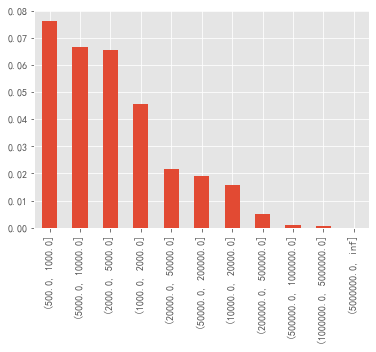

In [4]:
sections = [500,1000,2000,5000,10000,20000,50000,200000,500000,1000000,5000000,np.inf]
(pd.cut(tmp_df['txn_amt'],sections).value_counts()/tmp_df['txn_amt'].shape[0]).plot(kind='bar')

In [53]:
from joblib import Parallel, delayed
def sum_by_date(df):
    return df.groupby('date').sum()

def seq_filter_in(seq, threshold):
    return seq.loc[seq['txn_amt']<=threshold]

def seq_filter_out(seq, threshold):
    return seq.loc[seq['txn_amt']>=threshold]

def drop_trade_threshold(df,threshold):
    df = df.loc[df['txn_amt']<=threshold]
    return df

def get_daily_cash_req(tmp_df):
    tmp_df = tmp_df.sort_values(by=['date','prest_txn_tm'])
    tmp_group = tmp_df.groupby('date')
    tmp_group = tmp_group.cumsum()
    daily_cash_req = tmp_group.groupby('date').min()
    daily_cash_req = daily_cash_req.rename(columns={'txn_amt':'cash_req'})
    return daily_cash_req

def autocorrelation(timeseries, lags):
    import statsmodels.api as sm
    fig = plt.figure(figsize=(12, 8))
    plt.suptitle(timeseries.name, fontsize=20)
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()
    
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

#定义模型预测
def model_forcast(history, config):
    order, sorder, trend = config
    model = sm.tsa.statespace.SARIMAX(history, order=order, seasonal_order=soder,
                                     enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]
#one_step滚动向前预测
def forward_valid(data, n_test, config):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        yhat = model_forcast(history, config)
        prediction.append(yhat)
        history.append[test[i]]
    error = mape(test, predictions)
    return error
#模型评估
def score_model(data, n_test, config, debug=False):
    result = None
    key = str(config)
    if debug:
        result = forward_valid(data, n_test, config)
    else:
        try:
            with catch_warnings():
                filterwarinings("ignore")
                result = forward_valid(data, n_test, config)
        except:
            error = None
    return (key, result)

#网格搜索
def grid_search(data, config_list, n_test, parallel=True):
    score = None
    if parallel:
    # 使用计算机全部的cpu核数多线程并行
        executor = Parallel(n_jobs=-1, backend='multiprocessing')
        task = (delayed(score_model)(data, n_test, config) for config in config_list)
        scores = executors(task)
    
    else:
        scores = [score_model(data, n_test, cfg) for config in config_list]
    scores = [r for r in scores if r[i] != None]
    scores.sort(key=lambda x: x[1])
    return scores

def sarima_config(seasonal = [0]):
    p = d = q = [0,1,2]
    pdq = list(product(p, d, q))
    s = 0
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(product(p, d, q))]
    t = ['n', 'c', 't', 'ct']
    
    return list(product(pdq, seasonal_pdq, t))
    
    
        
    
    
# df_t = drop_trade_threshold(tmp_df, np.inf)
# plt.style.use('ggplot')
# fig = plt.subplots(figsize=(15,5))
# get_daily_cash_req(df_t)['cash_req'].plot()

In [54]:
sarima_config()

[((0, 0, 0), (0, 0, 0, 0), 'n'),
 ((0, 0, 0), (0, 0, 0, 0), 'c'),
 ((0, 0, 0), (0, 0, 0, 0), 't'),
 ((0, 0, 0), (0, 0, 0, 0), 'ct'),
 ((0, 0, 0), (0, 0, 1, 0), 'n'),
 ((0, 0, 0), (0, 0, 1, 0), 'c'),
 ((0, 0, 0), (0, 0, 1, 0), 't'),
 ((0, 0, 0), (0, 0, 1, 0), 'ct'),
 ((0, 0, 0), (0, 0, 2, 0), 'n'),
 ((0, 0, 0), (0, 0, 2, 0), 'c'),
 ((0, 0, 0), (0, 0, 2, 0), 't'),
 ((0, 0, 0), (0, 0, 2, 0), 'ct'),
 ((0, 0, 0), (0, 1, 0, 0), 'n'),
 ((0, 0, 0), (0, 1, 0, 0), 'c'),
 ((0, 0, 0), (0, 1, 0, 0), 't'),
 ((0, 0, 0), (0, 1, 0, 0), 'ct'),
 ((0, 0, 0), (0, 1, 1, 0), 'n'),
 ((0, 0, 0), (0, 1, 1, 0), 'c'),
 ((0, 0, 0), (0, 1, 1, 0), 't'),
 ((0, 0, 0), (0, 1, 1, 0), 'ct'),
 ((0, 0, 0), (0, 1, 2, 0), 'n'),
 ((0, 0, 0), (0, 1, 2, 0), 'c'),
 ((0, 0, 0), (0, 1, 2, 0), 't'),
 ((0, 0, 0), (0, 1, 2, 0), 'ct'),
 ((0, 0, 0), (0, 2, 0, 0), 'n'),
 ((0, 0, 0), (0, 2, 0, 0), 'c'),
 ((0, 0, 0), (0, 2, 0, 0), 't'),
 ((0, 0, 0), (0, 2, 0, 0), 'ct'),
 ((0, 0, 0), (0, 2, 1, 0), 'n'),
 ((0, 0, 0), (0, 2, 1, 0), 'c'),
 ((

In [6]:
tmp_df_in = tmp_df.loc[tmp_df['txn_amt']>=0]
tmp_df_out = tmp_df.loc[tmp_df['txn_amt']<=0]

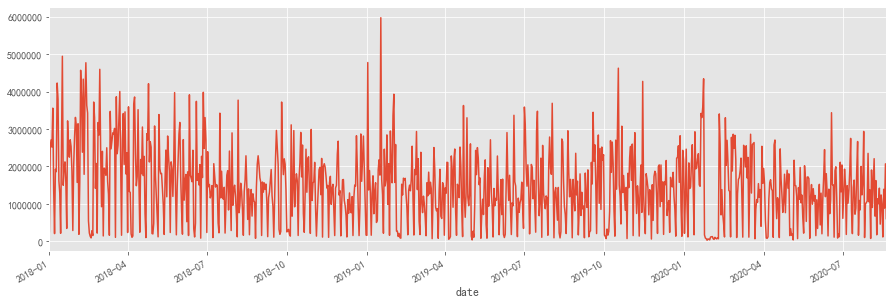

In [7]:
plt.style.use('ggplot')
fig = plt.subplots(figsize=(15,5))
daily_in_seq = sum_by_date(seq_filter_in(tmp_df_in, 500000))['txn_amt']
daily_in_seq.plot()
# sum_by_date(tmp_df_in)

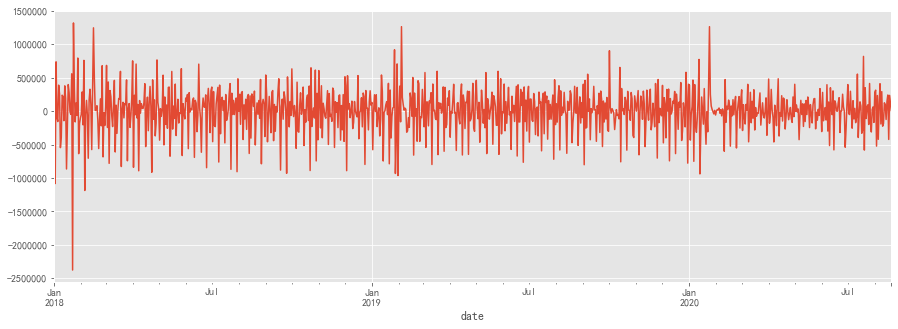

In [8]:

fig = plt.subplots(figsize=(15,5))
daily_out_seq = sum_by_date(seq_filter_out(tmp_df_out, -50000))['txn_amt']
daily_out_seq.diff(1).fillna(0).plot()
# sum_by_date(tmp_df_in)

In [9]:
res = sm.tsa.adfuller(daily_in_seq, regression='ct')
print('in_seq:',res[1])
res = sm.tsa.adfuller(daily_out_seq, regression='ct')
print('out_seq:',res[1])

in_seq: 1.8639108576886596e-05
out_seq: 1.2465436452524607e-05


In [10]:
res = sm.tsa.adfuller(daily_in_seq.diff().fillna(0), regression='c')
print('in_seq_diff',res[1])
res = sm.tsa.adfuller(daily_out_seq.diff().fillna(0), regression='c')
print('out_seq_diff',res[1])

in_seq_diff 1.1079519497922708e-20
out_seq_diff 5.125545285290596e-17


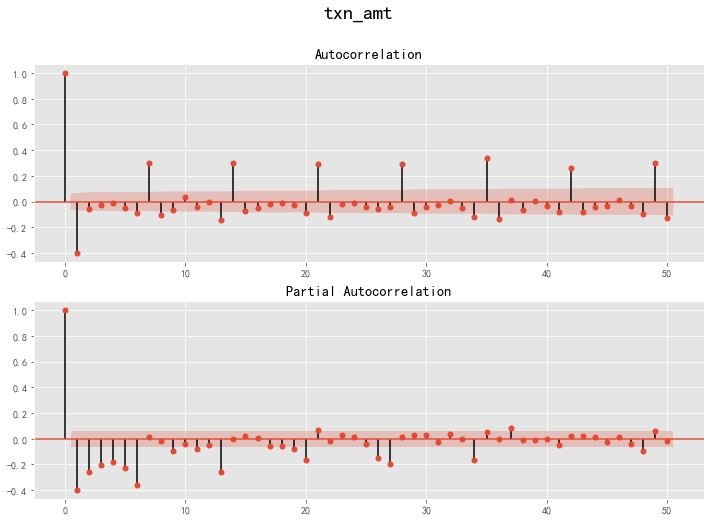

In [11]:
autocorrelation(daily_in_seq.diff().fillna(0), 50)

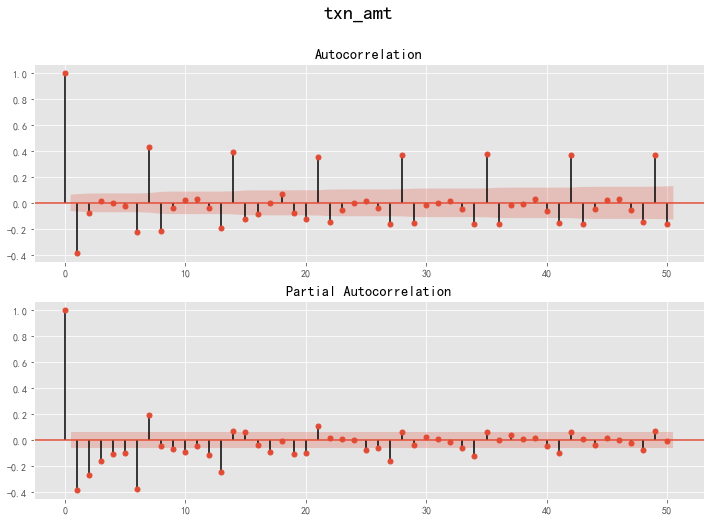

In [12]:
autocorrelation(daily_out_seq.diff().fillna(0), 50)

In [22]:
start = time.time()
order_evaluate = sm.tsa.arma_order_select_ic(daily_out_seq,ic='aic', trend='c', max_ar=7, max_ma=7)
print('ARMA(p,q) =',order_evaluate['aic_min_order'],'is the best.')
end = time.time()
print(end-start)

C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Us

ARMA(p,q) = (7, 7) is the best.
497.9602189064026


C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [44]:
start = time.time()
order_evaluate = sm.tsa.arma_order_select_ic(daily_out_seq.diff().fillna(0),ic='aic', trend='c', max_ar=7, max_ma=7)
print('ARMA(p,q) =',order_evaluate['aic_min_order'],'is the best.')
end = time.time()
print(end-start)

C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Te

ARMA(p,q) = (6, 7) is the best.
422.5582203865051


C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [28]:
arima = sm.tsa.statespace.SARIMAX(daily_out_seq[:'20200531'], order=(7,1,7), freq='D', seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False).fit()
arima.summary()

C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                txn_amt   No. Observations:                  882
Model:               SARIMAX(7, 1, 7)   Log Likelihood              -12072.539
Date:                Thu, 10 Sep 2020   AIC                          24175.079
Time:                        17:19:32   BIC                          24246.658
Sample:                    01-01-2018   HQIC                         24202.462
                         - 05-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3127      0.037     -8.405      0.000      -0.386      -0.240
ar.L2         -0.3701      0.029    -12.689      0.000      -0.427      -0.313
ar.L3         -0.3438      0.035     -9.801      0.000      -0.413      -0.275
ar.L4         -0.3384      0.032    -10.524      0.000      -0.401      -0.275
ar.L5         -0.3777      0.031    -12.029      0.000      -0.439      -0.316
ar.L6         -0.3089      0.036     -8.614      0.000      -0.379      -0.239
ar.L7          0.6070      0.028     21.914      0.000       0.553       0.661
ma.L1         -0.1356      0.033     -4.110      0.000      -0.200      -0.071
ma.L2          0.1437      0.026      5.488      0.000       0.092       0.195
ma.L3          0.0073      0.031      0.234      0.815      -0.054       0.069
ma.L4          0.0131      0.031      0.422      0.673      -0.048       0.074
ma.L5          0.1180      0.031      3.826      0.000       0.058       0.178
ma.L6         -0.1299      0.030     -4.351      0.000      -0.188      -0.071
ma.L7         -0.7270      0.024    -30.686      0.000      -0.773      -0.681
sigma2      5.996e+10   3.67e-13   1.63e+23      0.000       6e+10       6e+10
===================================================================================
Ljung-Box (Q):                       65.04   Jarque-Bera (JB):              2328.83
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+38. Standard errors may be unstable.
"""

ARIMA model RMSE:184779.75956164562
ARIMA model MAE:141250.34423706762
ARIMA model MAPE:50.946894812234


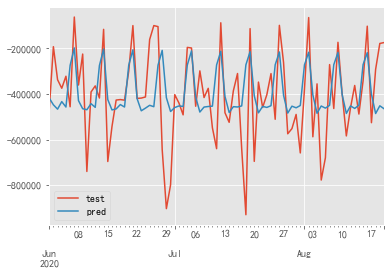

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
pred = arima.predict(start='20200531',end='20200820')[1:]
print('ARIMA model RMSE:{}'.format(np.sqrt(mean_squared_error(daily_out_seq['20200601':'20200820'],pred))))
print('ARIMA model MAE:{}'.format(mean_absolute_error(daily_out_seq['20200601':'20200820'],pred)))
print('ARIMA model MAPE:{}'.format(mape(daily_out_seq['20200601':'20200820'],pred)))
pd.DataFrame({'test':daily_out_seq['20200601':'20200820'],'pred':pred}).plot()
plt.show()

In [30]:
arima = sm.tsa.statespace.SARIMAX(daily_out_seq[:'20200531'], order=(7,1,7), freq='D', seasonal_order=(7,1,7,4),
                                 enforce_stationarity=False, enforce_invertibility=False).fit()
arima.summary()

C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                           txn_amt   No. Observations:                  882
Model:             SARIMAX(7, 1, 7)x(7, 1, 7, 4)   Log Likelihood              -11621.999
Date:                           Thu, 10 Sep 2020   AIC                          23301.999
Time:                                   17:22:00   BIC                          23439.302
Sample:                               01-01-2018   HQIC                         23354.620
                                    - 05-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0952      0.190     -0.502      0.615      -0.467       0.276
ar.L2         -0.3615      0.146     -2.479      0.013      -0.647      -0.076
ar.L3         -0.7358      0.200     -3.676      0.000      -1.128      -0.344
ar.L4         -0.0366      0.126     -0.291      0.771      -0.283       0.210
ar.L5         -0.3221      0.096     -3.347      0.001      -0.511      -0.133
ar.L6         -0.3788      0.134     -2.821      0.005      -0.642      -0.116
ar.L7          0.3492      0.108      3.230      0.001       0.137       0.561
ma.L1         -0.4803      0.190     -2.527      0.012      -0.853      -0.108
ma.L2          0.1369      0.206      0.665      0.506      -0.267       0.541
ma.L3          0.4089      0.218      1.875      0.061      -0.019       0.836
ma.L4         -0.7096      0.139     -5.116      0.000      -0.981      -0.438
ma.L5          0.1455      0.181      0.806      0.420      -0.208       0.499
ma.L6          0.0072      0.171      0.042      0.967      -0.328       0.343
ma.L7         -0.6903      0.189     -3.656      0.000      -1.060      -0.320
ar.S.L4       -0.8406      0.116     -7.231      0.000      -1.068      -0.613
ar.S.L8       -0.8427      0.100     -8.443      0.000      -1.038      -0.647
ar.S.L12      -0.8679      0.113     -7.713      0.000      -1.088      -0.647
ar.S.L16      -0.8243      0.107     -7.689      0.000      -1.034      -0.614
ar.S.L20      -0.8805      0.103     -8.551      0.000      -1.082      -0.679
ar.S.L24      -0.8067      0.110     -7.312      0.000      -1.023      -0.590
ar.S.L28       0.1305      0.092      1.417      0.157      -0.050       0.311
ma.S.L4        0.0530      0.091      0.583      0.560      -0.125       0.231
ma.S.L8        0.0315      0.064      0.491      0.623      -0.094       0.157
ma.S.L12       0.1023      0.065      1.577      0.115      -0.025       0.229
ma.S.L16       0.0134      0.063      0.213      0.832      -0.110       0.137
ma.S.L20       0.1421      0.062      2.306      0.021       0.021       0.263
ma.S.L24      -0.0316      0.068     -0.466      0.641      -0.164       0.101
ma.S.L28      -0.7681      0.063    -12.244      0.000      -0.891      -0.645
sigma2      7.906e+10   8.09e-12   9.77e+21      0.000    7.91e+10    7.91e+10
===================================================================================
Ljung-Box (Q):                       42.67   Jarque-Bera (JB):               234.62
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covarianc

ARIMA model RMSE:188254.75723412752
ARIMA model MAE:143531.8051177992
ARIMA model MAPE:48.09517644283402


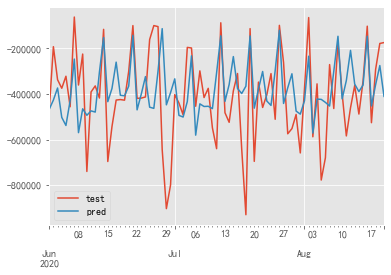

In [32]:
from sklearn.metrics import mean_squared_error
pred = arima.predict(start='20200531',end='20200820')[1:]
print('ARIMA model RMSE:{}'.format(np.sqrt(mean_squared_error(daily_out_seq['20200601':'20200820'],pred))))
print('ARIMA model MAE:{}'.format(mean_absolute_error(daily_out_seq['20200601':'20200820'],pred)))
print('ARIMA model MAPE:{}'.format(mape(daily_out_seq['20200601':'20200820'],pred)))
pd.DataFrame({'test':daily_out_seq['20200601':'20200820'],'pred':pred}).plot()
plt.show()